# Practical Time Series Analysis

## Week 4: AR(p) processes, Yule-Walker equations, PACF

**1. PACF**

**2. Yule-Walker**

**3. Examples and Datasets**

In [1]:
# devtools::install_github("FinYang/tsdl")

In [2]:
library(tsdl)
library(isdals)
library(ppcor)

Loading required package: MASS


## 1. PACF

### 1.1. General idea

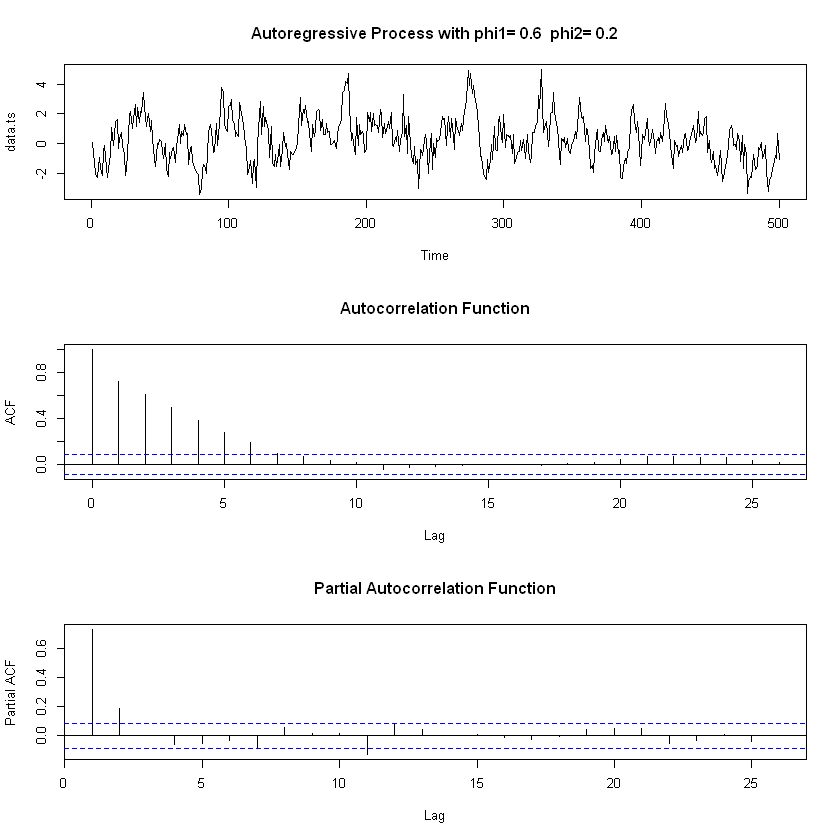

In [3]:
# AR(2) process
par(mfrow=c(3,1))

phi.1 = .6
phi.2 = .2
data.ts = arima.sim(n = 500, list(ar = c(phi.1, phi.2)))

plot(data.ts, main= paste("Autoregressive Process with phi1=",phi.1," phi2=",phi.2) )
acf(data.ts, main="Autocorrelation Function")
acf(data.ts, type="partial", main="Partial Autocorrelation Function")

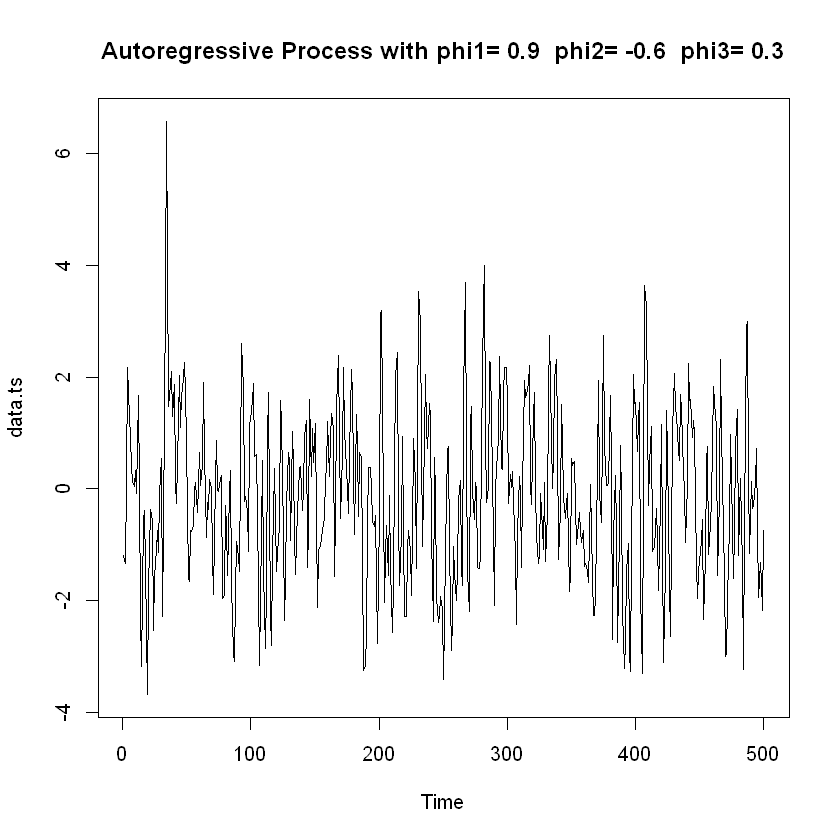

In [4]:
# AR(3) process
phi.1 = .9
phi.2 = -.6
phi.3 = .3
data.ts = arima.sim(n = 500, list(ar = c(phi.1, phi.2, phi.3)))
plot(data.ts, main= paste("Autoregressive Process with phi1=", phi.1," phi2=",phi.2," phi3=",phi.3) ) 

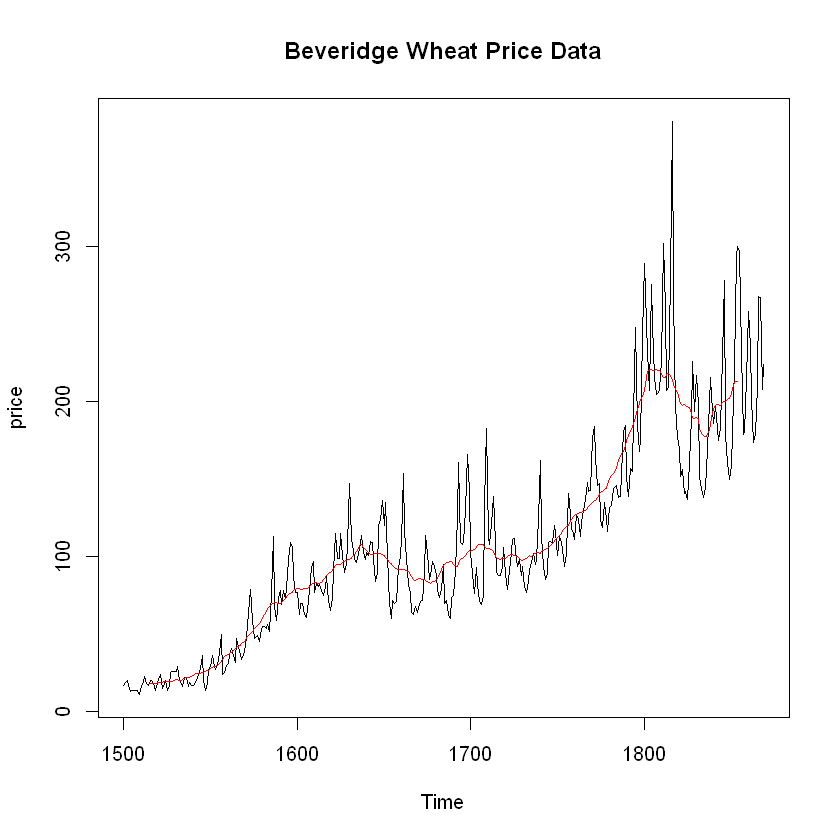

In [5]:
# Beveridge Wheat Price Time Series
beveridge = subset(tsdl, description = "Beveridge")[[1]]
beveridge.ts = ts(beveridge, start=1500)
plot( beveridge.ts, ylab="price", main="Beveridge Wheat Price Data")
beveridge.MA = filter(beveridge.ts, rep(1/31, 31), sides = 2)
lines(beveridge.MA, col="red")

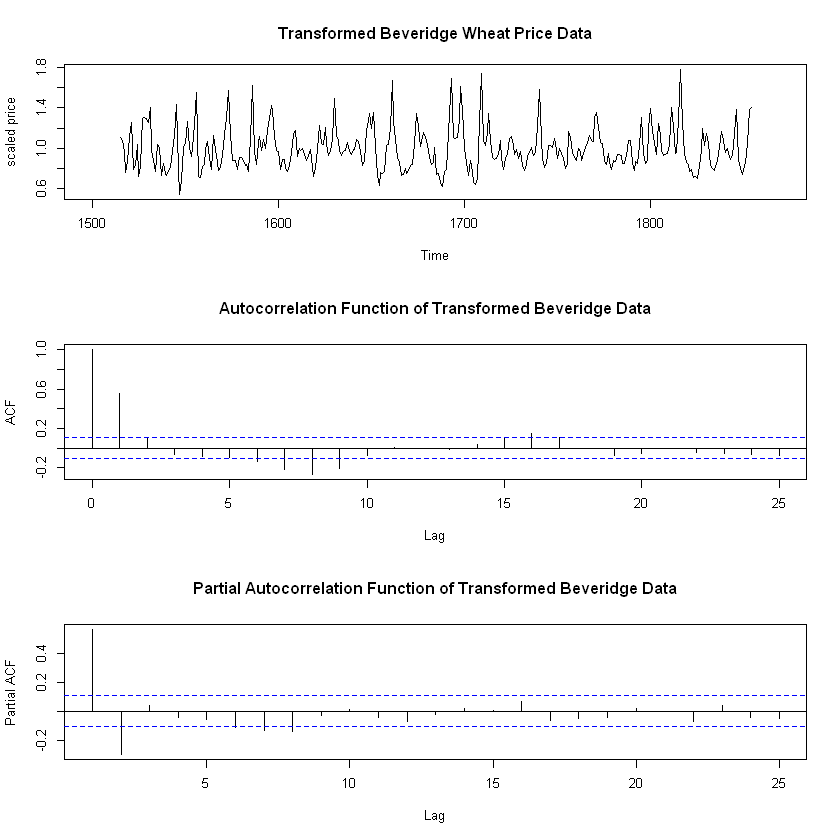

In [6]:
# Scale price by MA process
par(mfrow=c(3,1))

Y =  beveridge.ts / beveridge.MA
plot( Y, ylab="scaled price", main="Transformed Beveridge Wheat Price Data")
acf(na.omit(Y), main="Autocorrelation Function of Transformed Beveridge Data")
acf(na.omit(Y), type="partial",  main="Partial Autocorrelation Function of Transformed Beveridge Data") 

In [7]:
ar(na.omit(Y), order.max = 5)


Call:
ar(x = na.omit(Y), order.max = 5)

Coefficients:
      1        2  
 0.7239  -0.2957  

Order selected 2  sigma^2 estimated as  0.02692

**AR($p$) has a PACF that cuts off after $p$ lags.**

### 1.2. PACF Definition

**Bodyfat dataset:**

* Fat: body fat
* Thigh: thigh circumference
* Triceps: triceps skinfold measurement
* Midarm: mid-arm circumference

**Goal:** measure the correlation of Fat and Triceps, after controlling for or "partialling out" Thigh

**Method:** look at the residuals of Fat and Triceps after regressing both of them on Thigh

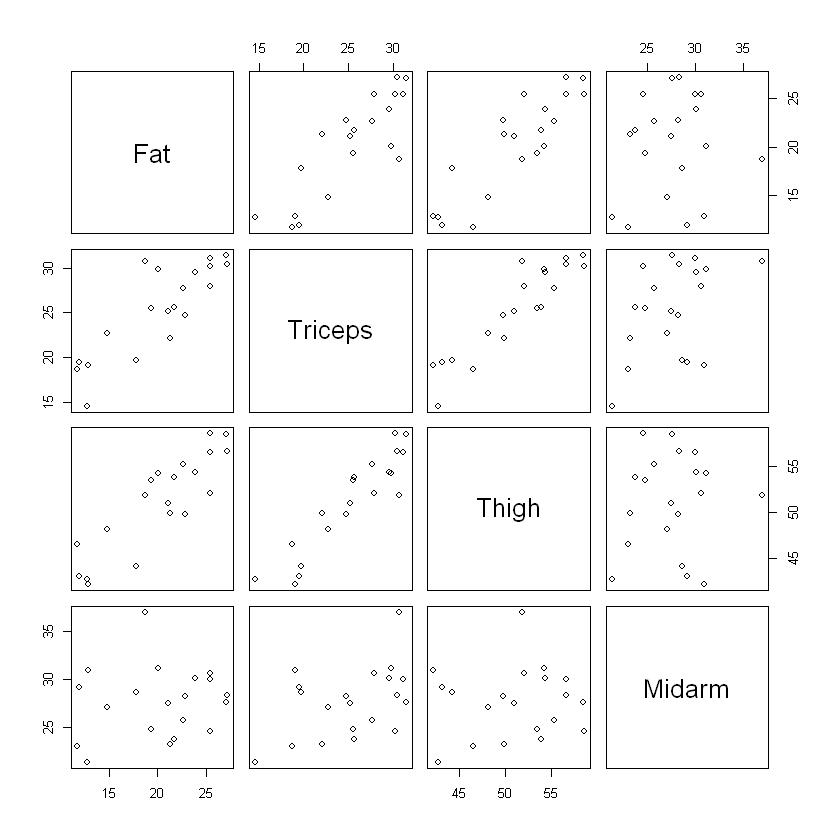

In [8]:
# bodyfat dataset
data(bodyfat)
attach(bodyfat)
pairs( cbind( Fat, Triceps, Thigh, Midarm) ) 

In [9]:
# correlations
cor( cbind( Fat, Triceps, Thigh, Midarm) )

,Fat,Triceps,Thigh,Midarm
Fat,1.0000000,0.8432654,0.8780896,0.1424440
Triceps,0.8432654,1.0000000,0.9238425,0.4577772
Thigh,0.8780896,0.9238425,1.0000000,0.0846675
Midarm,0.1424440,0.4577772,0.0846675,1.0000000


In [10]:
# correlation between Fat and Triceps regression residuals on Thigh
Fat.hat = predict(lm(Fat~Thigh))
Triceps.hat = predict( lm(Triceps~Thigh) )
cor( (Fat- Fat.hat), (Triceps- Triceps.hat) ) 

[1] 0.1749822

In [11]:
# ppcor for controled residuals for all variables
pcor( cbind( Fat, Triceps, Thigh) ) # same result

,Fat,Triceps,Thigh
Fat,1.0000000,0.1749822,0.4814109
Triceps,0.1749822,1.0000000,0.7130120
Thigh,0.4814109,0.7130120,1.0000000
,Fat,Triceps,Thigh
Fat,0.00000000,0.4736789763,0.0368987227
Triceps,0.47367898,0.0000000000,0.0006109801
Thigh,0.03689872,0.0006109801,0.0000000000
,Fat,Triceps,Thigh
Fat,0.0000000,0.7327755,2.264597
Triceps,0.7327755,0.0000000,4.192849


In [12]:
# correlation between Fat and Triceps controlling for Thigh and Midarm
Fat.hat = predict(lm(Fat~Thigh+Midarm))
Triceps.hat  = predict( lm(Triceps~Thigh+Midarm) )
cor( (Fat- Fat.hat), (Triceps- Triceps.hat) )

[1] 0.33815

In [13]:
# ppcor for controled residuals for all variables
pcor( cbind( Fat, Triceps, Thigh, Midarm) )

,Fat,Triceps,Thigh,Midarm
Fat,1.0000000,0.3381500,-0.2665991,-0.3240520
Triceps,0.3381500,1.0000000,0.9963725,0.9955918
Thigh,-0.2665991,0.9963725,1.0000000,-0.9926612
Midarm,-0.3240520,0.9955918,-0.9926612,1.0000000
,Fat,Triceps,Thigh,Midarm
Fat,0.0000000,1.699111e-01,2.848944e-01,1.895628e-01
Triceps,0.1699111,0.000000e+00,1.490492e-18,7.071386e-18
Thigh,0.2848944,1.490492e-18,0.000000e+00,4.134178e-16
Midarm,0.1895628,7.071386e-18,4.134178e-16,0.000000e+00
,Fat,Triceps,Thigh,Midarm


**Back to AR(p) Processes**

Estimate by looking **backward** over the last several terms and denote by $\hat{x}_{t + h}$ the regression of term $x_{t + h}$:

$
\hat{x}_{t+h} = \beta_1 x_{t+h-1} + \beta_2 x_{t+h-2} + ... + \beta_{h - 1} x_{t+1}
$

Estimate by looking **forward** over the next several terms and denote by $\hat{x}_{t}$ the regression of term $x_{t}$:

$
\hat{x}_{t} = \beta_1 x_{t+1} + \beta_2 x_{t+2} + ... + \beta_{h - 1} x_{t+h-1}
$

Define a partial autocorrelation function:

$
corr[(x_{t+h} - \hat{x}_{t+h}), (x_t - \hat{x}_t)]
$

We remove the linear effects of all the terms between the two random variables.

The excess correlation at $lag = k$ not accounted for by a $(k - 1)^{st}$ order model, is the partial correlation at $lag = k$.

## 2. Yule-Walker

Consider AR(p) process

$
X_t = \phi_0 + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_p X_{t-p} + Z_t \space (1)
$

where $Z_t \sim Normal(0, \sigma^2_z)$

Taking expectation from both sides of the model, considering it as stationary:

$
\mu = \phi_0 + \phi_1 \mu + \phi_2 \mu + ... \phi_p \mu \space (2)
$

Subtract side by side (1) - (2):

$
X_t - \mu = \phi_1 (X_{t-1} - \mu) + \phi_2 (X_{t-2} - \mu) + ... \phi_p(X_{t-p} - \mu) + Z_t
$

If $\tilde{X}_t = X_t - \mu$, then $E[\tilde{X}_t] = 0$, and:

$
\tilde{X}_t = \phi_1 \tilde{X}_{t-1} + \phi_2 \tilde{X}_{t-2} + ... \phi_p \tilde{X}_{t-p} + Z_t
$

AR(p) process with $\mu = 0$:

$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_p X_{t-p} + Z_t \space
$

Autocorrelation function obeys (Yule-Walker equation):

$
\rho(k) = \phi_1 \rho(k-1) + \phi_2 \rho(k-2) + ... + \phi_p \rho(k-p)
$

for $K \geq 1, \rho(0) = 1$ and $\rho(k) = \rho(-k)$ for $k < 0$.

To find the matrix form for Yule-Walker equations, we should write the equation above for $k = 1,2,...,p$.

**Example 1 - AR(2) Simulation**

$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + Z_t
$

where $Z_t \sim Normal(0, \sigma^2_z)$

We simulate this process for:

$
\phi_1 = \frac{1}{3}, \phi_2 = \frac{1}{2}, \sigma_Z = 4
$

We estimate coefficients of the model by first finding $r_1, r_2$ using ```acf()``` routine, then solving the system of equations bellow:

\begin{equation}
    \begin{bmatrix}
        r_1 \\
        r_2
    \end{bmatrix} 
    =
    \begin{bmatrix}
        1 & r_1 \\
        r_1 & 1
    \end{bmatrix}
    \begin{bmatrix}
        \hat{\phi_1} \\
        \hat{\phi_2}
    \end{bmatrix}
\end{equation}

We can estimate $\sigma_Z$ by taking the variance of both sides of the AR(2) equation, thus, obtaining:

$
\sigma_Z^2 = \gamma(0)[1 - \phi_1^2 - \phi_2^2 - 2 \phi_1 \phi_2 \rho_1]
$

And, from Yule-Walker Equation, we can re write this as:

$
\hat{\sigma}^2_Z = c_0[1 - \hat{\phi}_1 r_1 - \hat{\phi}_2 r_2]
$

In [24]:
# set seed
set.seed(2017)

# model parameters (we will estimate them)
sigma = 4
phi = NULL
phi[1:2] = c(1/3, 1/2)
phi

[1] 0.3333333 0.5000000

In [31]:
# number of data points
n = 10000

# simulate ar process
ar.process = arima.sim(n, model = list(ar = c(1/3, 1/2)), sd = 4)
ar.process[1:5]

[1] -5.9563600  0.4243643 -4.8956258 -4.0066647 -4.6184126

In [32]:
# find and name 2nd and 3rd sample autocorrelation
r = NULL
r[1:2] = acf(ar.process, plot = F)$acf[2:3]
r

[1] 0.6833965 0.7320110

In [33]:
# matrix R
R = matrix(1, 2, 2) # matrix 2x2 with all values equal to 1
R

1,1
1,1


In [34]:
# edit R
R[1,2] = r[1]
R[2,1] = r[1]
R

1.0000000,0.6833965
0.6833965,1.0000000


In [35]:
# b-column vector on the right
b = matrix(r, nrow = 2, ncol = 1)
b

0.6833965
0.7320110


In [36]:
# solve(R, b) solves Rx = b, and gives x = R^(-1)b vector
phi.hat = solve(R, b)
phi.hat

0.3436272
0.4971773


In [37]:
# variance estimation
c0=acf(ar.process, type='covariance', plot=F)$acf[1]
var.hat=c0*(1-sum(phi.hat*r))
var.hat

[1] 15.87462

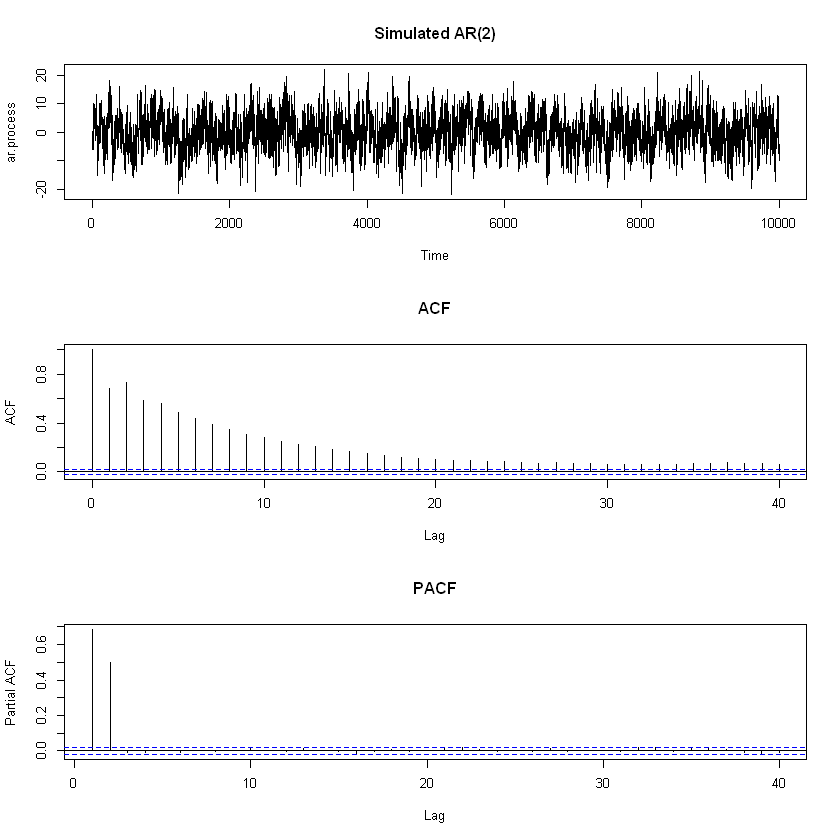

In [38]:
# plot time series, along with acf, pacf
par(mfrow=c(3,1))
plot(ar.process, main='Simulated AR(2)')
acf(ar.process, main='ACF')
pacf(ar.process, main='PACF')

Results:

* $\phi_1 \approx \hat{\phi}_1 = 0.3436272$
* $\phi_2 \approx \hat{\phi}_2 = 0.4971773$
* $\sigma_Z^2 \approx \hat{\sigma}^2_Z = 15.8746232381646$

Actual Model:

$
X_t = 0.\bar{3} X_{t-1} + 0.5 X_{t-2} + Z_t, \qquad Z_t \sim N(0, 16)
$

Fitted model:

$
X_t = 0.3436272 X_{t-1} + 0.4971773 X_{t-2} + Z_t, \qquad Z_t \sim N(0, 15.8746232381646)
$

**Example 2 - AR(3) Simulation**

$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_3 X_{t-3} + Z_t
$

where $Z_t \sim Normal(0, \sigma^2_z)$

We simulate this process for:

$
\phi_1 = \frac{1}{3}, \phi_2 = \frac{1}{2}, \phi_3 = \frac{7}{100}, \sigma_Z = 4
$

We estimate coefficients of the model by first finding $r_1, r_2$ using ```acf()``` routine, then solving the system of equations bellow:

\begin{equation}
    \begin{bmatrix}
        r_1 \\
        r_2 \\
        r_3
    \end{bmatrix} 
    =
    \begin{bmatrix}
        1 & r_1 & r_2 \\
        r_1 & 1 & r_1 \\
        r_2 & r_1 & 1
    \end{bmatrix}
    \begin{bmatrix}
        \hat{\phi_1} \\
        \hat{\phi_2} \\
        \hat{\phi_3}
    \end{bmatrix}
\end{equation}

We can estimate $\sigma_Z$ by using the Yule-Walker estimator for $\sigma_Z^2$

$
\hat{\sigma}^2_Z = c_0(1 - \sum^{p}_{i = 1} \phi_i r_i)
$

In [40]:
# set seed, parameters to be estimated and number of data points
set.seed(2017)
sigma=4
phi=NULL
phi[1:3]=c(1/3,1/2,7/100)
n=100000

In [41]:
# simulate ar(3) process
ar3.process=arima.sim(n,model=list(ar=c(1/3,1/2, 7/100)), sd=4)

In [42]:
r=NULL
r[1:3]=acf(ar3.process, plot=F)$acf[2:4]
r

[1] 0.7859646 0.8180901 0.7369167

In [43]:
R=matrix(1,3,3) 
R[1,2]=r[1] 
R[1,3]=r[2]
R[2,1]=r[1]
R[2,3]=r[1]
R[3,1]=r[2]
R[3,2]=r[1]
R

1.0000000,0.7859646,0.8180901
0.7859646,1.0000000,0.7859646
0.8180901,0.7859646,1.0000000


In [44]:
# b-column vector on the right
b=matrix(,3,1)# b- column vector with no entries
b[1,1]=r[1]
b[2,1]=r[2]
b[3,1]=r[3]
b

0.7859646
0.8180901
0.7369167


In [51]:
# sigma estimation
c0=acf(ar3.process, type='covariance', plot=F)$acf[1]
var.hat=c0*(1-sum(phi.hat*r))
var.hat

[1] 0.9375

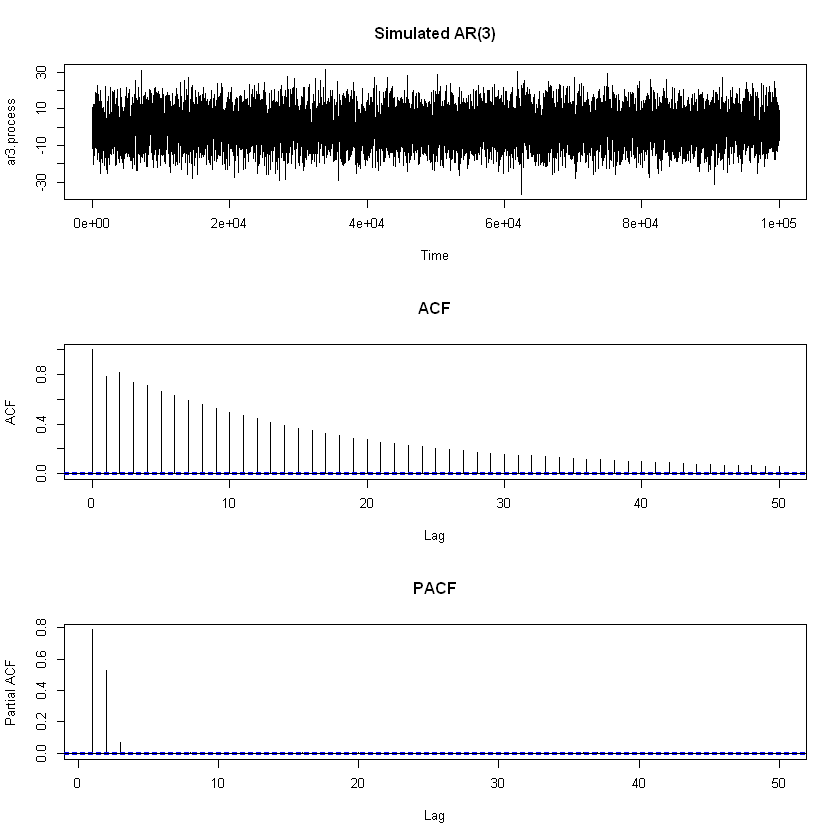

In [47]:
par(mfrow=c(3,1))
plot(ar3.process, main='Simulated AR(3)')
acf(ar3.process, main='ACF')
pacf(ar3.process, main='PACF')

Results:

* $\phi_1 \approx \hat{\phi}_1 = 0.33812448$
* $\phi_2 \approx \hat{\phi}_2 = 0.49849991$
* $\phi_3 \approx \hat{\phi}_3 = 0.06849712$
* $\sigma_Z^2 \approx \hat{\sigma}^2_Z = 15.9790027182324$

Actual Model:

$
X_t = 0.\bar{3} X_{t-1} + 0.5 X_{t-2} + 0.07 X_{t-3} + Z_t, \qquad Z_t \sim N(0, 16)
$

Fitted model:

$
X_t = 0.33812448 X_{t-1} + 0.49849991 X_{t-2} + 0.06849712 X_{t-3} + Z_t, \qquad Z_t \sim N(0, 15.9790027182324)
$